In [256]:
import yfinance as yf

In [257]:
sp500 = yf.Ticker("^GSPC")

In [258]:
sp500 = sp500.history(period='max')

In [ ]:
sp500.index

In [ ]:
sp500.plot.line(y="Close", use_index=True)

In [261]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [262]:
sp500 ['Tomorrow'] = sp500["Close"].shift(-1)

In [ ]:
sp500

In [264]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [265]:
sp500 = sp500.loc["1990-1-1":].copy()

In [ ]:
sp500
# sp500.plot.line(y="Close", use_index=True)

In [267]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train=sp500.iloc[:-100]
test=sp500.iloc[-100:]

predictors=["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])


RandomForestClassifier(min_samples_split=100, random_state=1)

In [268]:
test

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
2024-06-07 00:00:00-04:00,5343.810059,5375.080078,5331.330078,5346.990234,3692760000,5360.790039,1
2024-06-10 00:00:00-04:00,5341.220215,5365.790039,5331.520020,5360.790039,3622280000,5375.319824,1
2024-06-11 00:00:00-04:00,5353.000000,5375.950195,5327.250000,5375.319824,3568030000,5421.029785,1
2024-06-12 00:00:00-04:00,5409.129883,5447.250000,5409.129883,5421.029785,3962840000,5433.740234,1
2024-06-13 00:00:00-04:00,5441.930176,5441.930176,5402.509766,5433.740234,3530380000,5431.600098,0
...,...,...,...,...,...,...,...
2024-10-23 00:00:00-04:00,5834.500000,5834.850098,5762.410156,5797.419922,3532650000,5809.859863,1
2024-10-24 00:00:00-04:00,5817.799805,5817.799805,5784.919922,5809.859863,3543030000,5808.120117,0
2024-10-25 00:00:00-04:00,5826.750000,5862.819824,5799.979980,5808.120117,3501280000,5823.520020,1


In [269]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])



In [270]:
import pandas as pd
preds = pd.Series(preds, index=test.index, name="Predictions")

In [271]:

preds

Date
2024-06-07 00:00:00-04:00    0
2024-06-10 00:00:00-04:00    0
2024-06-11 00:00:00-04:00    0
2024-06-12 00:00:00-04:00    0
2024-06-13 00:00:00-04:00    0
                            ..
2024-10-23 00:00:00-04:00    0
2024-10-24 00:00:00-04:00    0
2024-10-25 00:00:00-04:00    0
2024-10-28 00:00:00-04:00    0
2024-10-29 00:00:00-04:00    0
Name: Predictions, Length: 100, dtype: int64

In [272]:
a= precision_score(test["Target"], preds)
print(a)

0.6666666666666666


In [273]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='Date'>

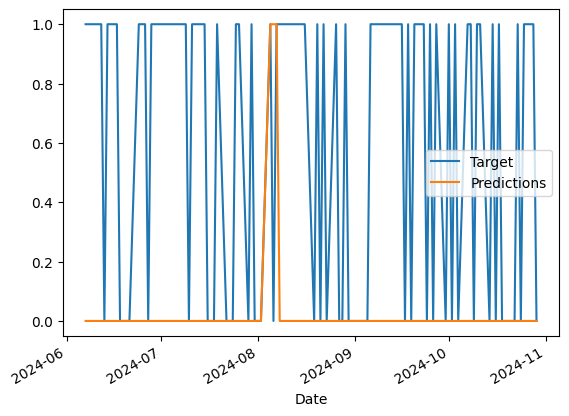

In [274]:
combined.plot()

In [275]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [276]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions= []

    for i in range (start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions=predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [277]:
prediction = backtest(sp500, model, predictors)


In [278]:
prediction["Predictions"].value_counts()

Predictions
0    3657
1    2617
Name: count, dtype: int64

In [279]:
precision_score(prediction["Target"], prediction["Predictions"])

np.float64(0.5288498280473825)

In [280]:
prediction["Target"].value_counts() / prediction.shape[0]

Target
1    0.535703
0    0.464297
Name: count, dtype: float64

In [281]:
horizons = [2, 5, 60, 250, 1000]

new_predictors=[]

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

    new_predictors = new_predictors + [ratio_column, trend_column]

sp500


,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,0.998706,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,0.995675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,0.995098,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,1.002252,1.0,0.993731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-23 00:00:00-04:00,5834.500000,5834.850098,5762.410156,5797.419922,3532650000,5809.859863,1,0.995383,0.0,0.992412,1.0,1.032494,34.0,1.121556,148.0,1.312488,528.0
2024-10-24 00:00:00-04:00,5817.799805,5817.799805,5784.919922,5809.859863,3543030000,5808.120117,0,1.001072,1.0,0.995619,2.0,1.033827,34.0,1.122509,149.0,1.314560,528.0
2024-10-25 00:00:00-04:00,5826.750000,5862.819824,5799.979980,5808.120117,3501280000,5823.520020,1,0.999850,1.0,0.997254,1.0,1.032411,34.0,1.120709,149.0,1.313441,527.0


In [282]:
sp500 = sp500.dropna()
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22 00:00:00-04:00,5832.700195,5863.040039,5821.169922,5851.200195,3342080000,5797.419922,0,0.999763,0.0,1.000076,2.0,1.043190,34.0,1.133373,148.0,1.325421,528.0
2024-10-23 00:00:00-04:00,5834.500000,5834.850098,5762.410156,5797.419922,3532650000,5809.859863,1,0.995383,0.0,0.992412,1.0,1.032494,34.0,1.121556,148.0,1.312488,528.0
2024-10-24 00:00:00-04:00,5817.799805,5817.799805,5784.919922,5809.859863,3543030000,5808.120117,0,1.001072,1.0,0.995619,2.0,1.033827,34.0,1.122509,149.0,1.314560,528.0


In [283]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)


In [284]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6]=0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [285]:
prediction = backtest(sp500, model, new_predictors)


In [286]:
prediction["Predictions"].value_counts()

Predictions
0.0    4424
1.0     849
Name: count, dtype: int64

In [287]:
precision_score(prediction["Target"], prediction["Predictions"])

np.float64(0.574793875147232)

In [288]:

def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

sp500['RSI'] = calculate_rsi(sp500)


/tmp/ipykernel_28774/1285577220.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['RSI'] = calculate_rsi(sp500)


In [289]:

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    
    return macd, signal_line

sp500['MACD'], sp500['Signal_Line'] = calculate_macd(sp500)


/tmp/ipykernel_28774/3662551178.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['MACD'], sp500['Signal_Line'] = calculate_macd(sp500)
/tmp/ipykernel_28774/3662551178.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['MACD'], sp500['Signal_Line'] = calculate_macd(sp500)


In [290]:

def calculate_bollinger_bands(data, window=20):
    sma = data['Close'].rolling(window=window).mean()
    std_dev = data['Close'].rolling(window=window).std()
    
    upper_band = sma + (std_dev * 2)
    lower_band = sma - (std_dev * 2)
    
    return upper_band, lower_band

sp500['Upper_Band'], sp500['Lower_Band'] = calculate_bollinger_bands(sp500)


/tmp/ipykernel_28774/709129373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['Upper_Band'], sp500['Lower_Band'] = calculate_bollinger_bands(sp500)
/tmp/ipykernel_28774/709129373.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['Upper_Band'], sp500['Lower_Band'] = calculate_bollinger_bands(sp500)


In [291]:

new_technical_predictors = ['RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band']
predictors = predictors + new_technical_predictors


In [292]:

sp500.loc[:, 'RSI'] = calculate_rsi(sp500)
sp500.loc[:, 'MACD'], sp500.loc[:, 'Signal_Line'] = calculate_macd(sp500)
sp500.loc[:, 'Upper_Band'], sp500.loc[:, 'Lower_Band'] = calculate_bollinger_bands(sp500)


new_technical_predictors = ['RSI', 'MACD', 'Signal_Line', 'Upper_Band', 'Lower_Band']
predictors = predictors + new_technical_predictors

sp500 = sp500.dropna()

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]


print("Train columns: ", train.columns)

model.fit(train[predictors], train["Target"])

preds = model.predict(test[predictors])
precision = precision_score(test["Target"], preds)
print("Precision:", precision)


Train columns:  Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Tomorrow', 'Target',
       'Close_Ratio_2', 'Trend_2', 'Close_Ratio_5', 'Trend_5',
       'Close_Ratio_60', 'Trend_60', 'Close_Ratio_250', 'Trend_250',
       'Close_Ratio_1000', 'Trend_1000', 'RSI', 'MACD', 'Signal_Line',
       'Upper_Band', 'Lower_Band'],
      dtype='object')
Precision: 0.6923076923076923


In [293]:

train_preds = model.predict(train[predictors])


train_preds = pd.Series(train_preds, index=train.index, name="Train_Predictions")


train_combined = pd.concat([train["Target"], train_preds], axis=1)
test_combined = pd.concat([test["Target"], pd.Series(preds, index=test.index, name="Test_Predictions")], axis=1)


print("Train data comparison:\n", train_combined.head())
print("Test data comparison:\n", test_combined.head())


Train data comparison:
                            Target  Train_Predictions
Date                                                
1994-01-11 00:00:00-05:00       1                  1
1994-01-12 00:00:00-05:00       0                  1
1994-01-13 00:00:00-05:00       1                  1
1994-01-14 00:00:00-05:00       0                  1
1994-01-17 00:00:00-05:00       1                  1
Test data comparison:
                            Target  Test_Predictions
Date                                               
2024-06-06 00:00:00-04:00       0                 1
2024-06-07 00:00:00-04:00       1                 1
2024-06-10 00:00:00-04:00       1                 1
2024-06-11 00:00:00-04:00       1                 1
2024-06-12 00:00:00-04:00       1                 1


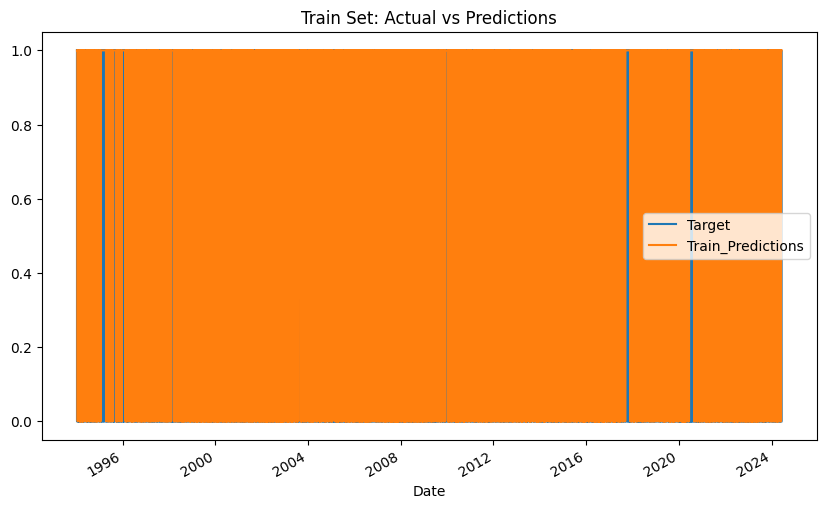

In [294]:



train_combined.plot(figsize=(10, 6), title="Train Set: Actual vs Predictions")
plt.show()




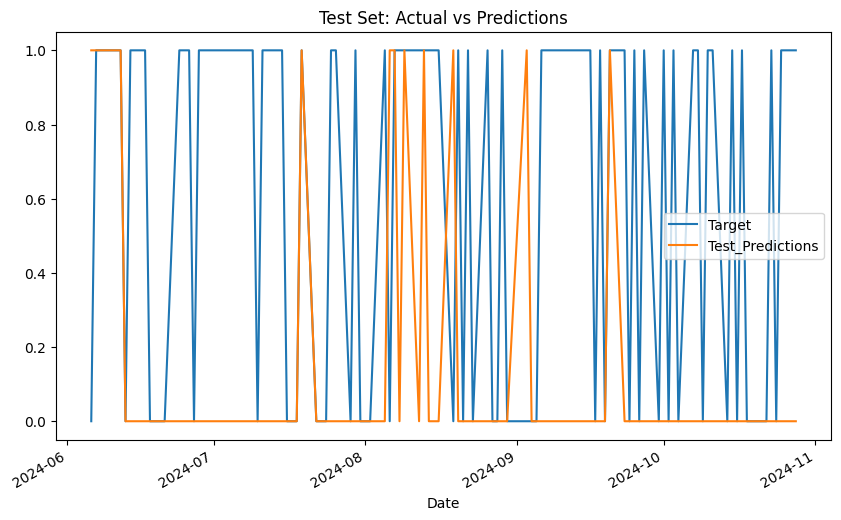

In [295]:
test_combined.plot(figsize=(10, 6), title="Test Set: Actual vs Predictions")
plt.show()


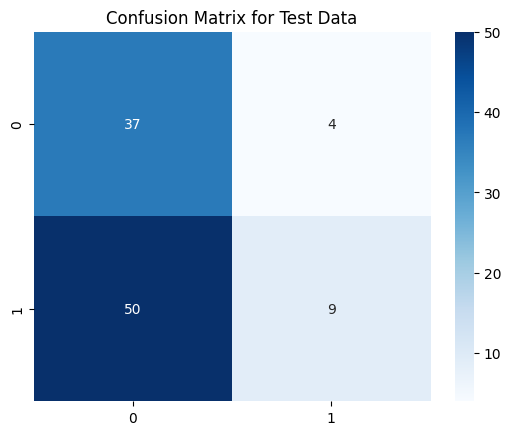

In [296]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


test_cm = confusion_matrix(test["Target"], preds)
sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Test Data")
plt.show()





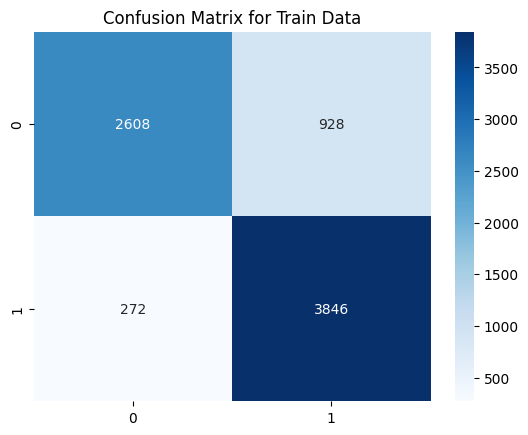

In [297]:
train_cm = confusion_matrix(train["Target"], train_preds)
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix for Train Data")
plt.show()

In [298]:
from sklearn.metrics import recall_score, f1_score


test_precision = precision_score(test["Target"], preds)
test_recall = recall_score(test["Target"], preds)
test_f1 = f1_score(test["Target"], preds)


train_precision = precision_score(train["Target"], train_preds)
train_recall = recall_score(train["Target"], train_preds)
train_f1 = f1_score(train["Target"], train_preds)

print(f"Test Precision: {test_precision}, Recall: {test_recall}, F1-Score: {test_f1}")
print(f"Train Precision: {train_precision}, Recall: {train_recall}, F1-Score: {train_f1}")


Test Precision: 0.6923076923076923, Recall: 0.15254237288135594, F1-Score: 0.25
Train Precision: 0.8056137410976121, Recall: 0.9339485186983972, F1-Score: 0.865047233468286
